In [ ]:
import tensorflow as tf
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
unzip = zipfile.ZipFile('/content/drive/MyDrive/GlyphDataset.zip')
unzip.extractall()
unzip.close()

In [ ]:
im = plt.imread('/content/Dataset/Automated/Preprocessed/20/200000_G43.png')
im.shape

(75, 50)

In [ ]:
all_dir = []
path='/content/Dataset/Automated/Preprocessed'
for i in os.listdir('/content/Dataset/Automated/Preprocessed'):
  all_dir.append(path+'/'+i)


In [ ]:
all_dir

['/content/Dataset/Automated/Preprocessed/22',
 '/content/Dataset/Automated/Preprocessed/23',
 '/content/Dataset/Automated/Preprocessed/5',
 '/content/Dataset/Automated/Preprocessed/20',
 '/content/Dataset/Automated/Preprocessed/39',
 '/content/Dataset/Automated/Preprocessed/3',
 '/content/Dataset/Automated/Preprocessed/9',
 '/content/Dataset/Automated/Preprocessed/21',
 '/content/Dataset/Automated/Preprocessed/7',
 '/content/Dataset/Automated/Preprocessed/41']

In [ ]:
import shutil

In [ ]:
labels=[]
for i in all_dir:
  for j in os.listdir(i):
    val=j[7:-4]
    if val not in labels and val!='UNKNOWN':
      p = os.path.join('./data_lab',val)
      os.makedirs(p)
      labels.append(val)


In [ ]:
for i in all_dir:
  for j in os.listdir(i):
    val=j[7:-4]
    p=os.path.join('/content/data_lab',val)
    x=os.path.join(i,j)
    shutil.copy(x,p)


In [ ]:
data_train, data_val = tf.keras.utils.image_dataset_from_directory('/content/data_lab', image_size=(70, 50), label_mode='categorical', batch_size=64, seed=42,validation_split=0.2,subset="both")

Found 3270 files belonging to 163 classes.
Using 2616 files for training.
Using 654 files for validation.


In [ ]:
data_augmentation_layer = data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation((-11,11)),
  tf.keras.layers.RandomZoom((0,0.15)),
  tf.keras.layers.GaussianNoise(0.3)
], name ="data_augmentation")

In [ ]:
def im_scale(img,label):
  img = img/255.
  return (img,label)

In [ ]:
train = data_train.map(im_scale,num_parallel_calls=tf.data.AUTOTUNE)
val =  data_val.map(im_scale,num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# prompt: see on image in the train

next(iter(train))


(<tf.Tensor: shape=(64, 70, 50, 3), dtype=float32, numpy=
 array([[[[0.74131656, 0.74131656, 0.74131656],
          [0.75602245, 0.75602245, 0.75602245],
          [0.72997195, 0.72997195, 0.72997195],
          ...,
          [0.7448179 , 0.7448179 , 0.7448179 ],
          [0.737535  , 0.737535  , 0.737535  ],
          [0.7448179 , 0.7448179 , 0.7448179 ]],
 
         [[0.74383754, 0.74383754, 0.74383754],
          [0.73249304, 0.73249304, 0.73249304],
          [0.7425771 , 0.7425771 , 0.7425771 ],
          ...,
          [0.7376751 , 0.7376751 , 0.7376751 ],
          [0.7434174 , 0.7434174 , 0.7434174 ],
          [0.7359944 , 0.7359944 , 0.7359944 ]],
 
         [[0.7368347 , 0.7368347 , 0.7368347 ],
          [0.7247899 , 0.7247899 , 0.7247899 ],
          [0.72086835, 0.72086835, 0.72086835],
          ...,
          [0.7369748 , 0.7369748 , 0.7369748 ],
          [0.72661066, 0.72661066, 0.72661066],
          [0.7219888 , 0.7219888 , 0.7219888 ]],
 
         ...,
 
        

In [ ]:
output_len=len(data_train.class_names)
output_len

163

In [ ]:
model_resNet50 = tf.keras.applications.ResNet50(include_top=False)
model_resNet50.trainable=False
input= tf.keras.layers.Input(shape=(70,50,3),name='input_layer')
aug = data_augmentation_layer(input)
x = model_resNet50(aug,training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
x = tf.keras.layers.Dense(256,activation='relu')(x)
outputs = tf.keras.layers.Dense(output_len, activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(input, outputs)

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
check_call = tf.keras.callbacks.ModelCheckpoint('model_check/model2_resNet50',save_best_only=True,monitor='val_accuracy')

In [ ]:
hist = model.fit(data_train,epochs=200,validation_data=data_val,callbacks=[check_call])

Epoch 1/200
41/41 [==============================] - 34s 634ms/step - loss: 3.1966 - accuracy: 0.3471 - val_loss: 2.9095 - val_accuracy: 0.3379
Epoch 2/200
41/41 [==============================] - 21s 526ms/step - loss: 2.2121 - accuracy: 0.5115 - val_loss: 2.3457 - val_accuracy: 0.5092
Epoch 3/200
41/41 [==============================] - 23s 564ms/step - loss: 1.8678 - accuracy: 0.5508 - val_loss: 2.1268 - val_accuracy: 0.5382
Epoch 4/200
41/41 [==============================] - 24s 594ms/step - loss: 1.6833 - accuracy: 0.6002 - val_loss: 1.9643 - val_accuracy: 0.5596
Epoch 5/200
41/41 [==============================] - 23s 564ms/step - loss: 1.5397 - accuracy: 0.6124 - val_loss: 1.8737 - val_accuracy: 0.5719
Epoch 6/200
41/41 [==============================] - 21s 529ms/step - loss: 1.4611 - accuracy: 0.6250 - val_loss: 1.7955 - val_accuracy: 0.5810
Epoch 7/200
41/41 [==============================] - 2s 42ms/step - loss: 1.3780 - accuracy: 0.6422 - val_loss: 1.8374 - val_accuracy: 0

In [ ]:
load_best = tf.keras.models.load_model('/content/model_check/model2_resNet50')

In [ ]:
load_best.save('hiero2_resNet2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
eval_best = load_best.evaluate(data_val)
eval_best

11/11 [==============================] - 3s 47ms/step - loss: 1.6131 - accuracy: 0.6621


[1.6131095886230469, 0.6620795130729675]

In [ ]:
from skimage.util.shape import view_as_windows


In [ ]:
read_im = plt.imread('/content/Dataset/Pictures/egyptianTexts20.jpg')
read_im.shape

(1583, 1071, 3)

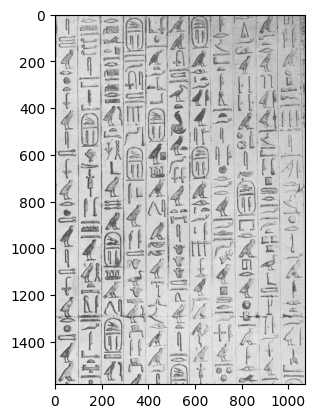

In [ ]:
plt.imshow(read_im)

In [ ]:
window_shape = (70, 50,3)
B = view_as_windows(read_im, window_shape)

In [ ]:
image_height, image_width, _ = read_im.shape

# Calculate starting and ending coordinates considering desired aspect ratio
start_y = (image_height - 240) // 2
end_y = start_y + 240
start_x = (image_width - 426) // 2
end_x = start_x + 426

# Check if coordinates fall outside image boundaries (adjust if needed)
if start_y < 0 or end_y > image_height or start_x < 0 or end_x > image_width:
    # Implement logic to handle edge cases like image being smaller than desired size
    print("Image too small for desired crop size")
    # ...

cropped_image = read_im[start_y:end_y, start_x:end_x]

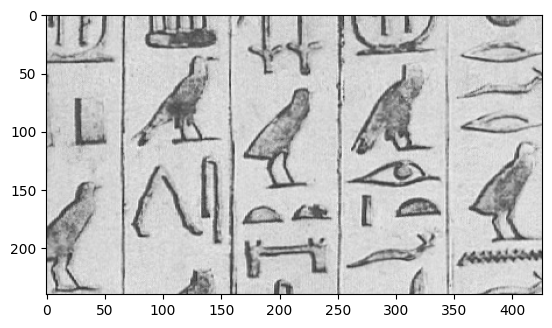

In [ ]:
plt.imshow(cropped_image)

In [ ]:
cropped_image.shape

(240, 426, 3)

In [ ]:
col=0

In [ ]:
im_1=cropped_image[0:70,col:col+50]

In [ ]:
im_1.shape

(70, 50, 3)

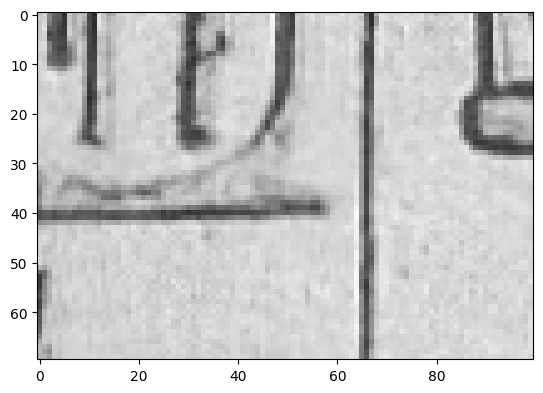

In [ ]:
plt.imshow(im_1)

In [ ]:
tf.expand_dims(im_1,axis=0)

<tf.Tensor: shape=(1, 70, 100, 3), dtype=uint8, numpy=
array([[[[197, 197, 197],
         [212, 212, 212],
         [133, 133, 133],
         ...,
         [208, 208, 208],
         [209, 209, 209],
         [126, 126, 126]],

        [[202, 202, 202],
         [209, 209, 209],
         [133, 133, 133],
         ...,
         [211, 211, 211],
         [204, 204, 204],
         [169, 169, 169]],

        [[198, 198, 198],
         [217, 217, 217],
         [121, 121, 121],
         ...,
         [203, 203, 203],
         [221, 221, 221],
         [193, 193, 193]],

        ...,

        [[181, 181, 181],
         [176, 176, 176],
         [162, 162, 162],
         ...,
         [216, 216, 216],
         [215, 215, 215],
         [226, 226, 226]],

        [[185, 185, 185],
         [162, 162, 162],
         [143, 143, 143],
         ...,
         [219, 219, 219],
         [223, 223, 223],
         [221, 221, 221]],

        [[178, 178, 178],
         [176, 176, 176],
         [156, 156,

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
def window_im(image):
  col=0
  row=70
  while image.shape[1]>col:
    im=image[:row,col:col+50]
    col=col+70
    pred=load_best.predict(tf.expand_dims(im,axis=0))
    predict = np.argmax(pred,axis=1)
    print(predict)
    cv2_imshow(image)
    cv2.rectangle(image,(0,row),(0,70),color=(255,0,0),thickness = 2)
    break

1/1 [==============================] - 0s 22ms/step
[114]


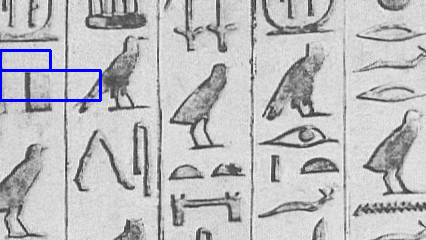

In [ ]:
window_im(cropped_image)

In [ ]:
data_train_2, data_val_2 = tf.keras.utils.image_dataset_from_directory('/content/data_lab', image_size=(70, 50), label_mode='categorical', seed=42,validation_split=0.2,subset="both")

Found 3270 files belonging to 163 classes.
Using 2616 files for training.
Using 654 files for validation.


In [ ]:
train_2 = data_train_2.map(im_scale,num_parallel_calls=tf.data.AUTOTUNE)
val_2 =  data_val_2.map(im_scale,num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
data_val_2.class_names[95]

'N35'

In [ ]:
img_list=[]
label_list = []
for image,label in train_2.unbatch().as_numpy_iterator():
  img_list.append(image)
  label_list.append(label)
x_train=np.array(img_list)
y_train=np.array(label_list)

In [ ]:
img_list=[]
label_list = []
for image,label in val_2.unbatch().as_numpy_iterator():
  img_list.append(image)
  label_list.append(label)
x_test=np.array(img_list)
y_test=np.array(label_list)

In [ ]:
x_test.shape,y_test.shape

((654, 70, 50, 3), (654, 163))

In [ ]:
x_train.shape

(2616, 70, 50, 3)

In [ ]:
y_=np.argmax(y_train,axis=1)
y_.shape[0],x_train.shape[0]

(2616, 2616)

Text(0.5, 1.0, '95')

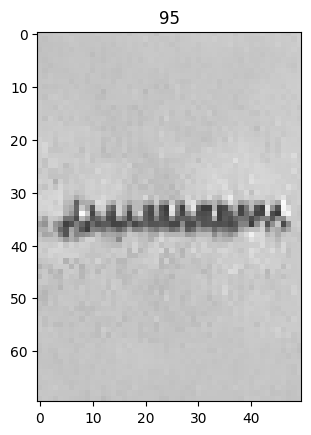

In [ ]:
plt.imshow(x_train[0])
plt.title((y_[0]))

In [ ]:
y_t=np.argmax(y_test,axis=1)
y_t.shape[0]

654

In [ ]:
for i in range(len(y_)):
  y_label = y_[i]
  indices_for_pos = np.where(y_ == y_label)[0]
  if indices_for_pos.size > 0:
    print(indices_for_pos.shape[0])

In [ ]:
def make_pairs(images, labels, seed=19):
    np.random.seed(seed)
    pairImages = []
    pairLabels = []

    numClasses = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(numClasses)]

    for idxA in range(len(images)):
        currentImage = images[idxA]
        label = labels[idxA]
        if label < len(idx):
          idxB = np.random.choice(idx[label])
        posImage = images[idxB]

        pairImages.append([currentImage, posImage])
        pairLabels.append([1])

        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]

        pairImages.append([currentImage, negImage])
        pairLabels.append([0])

    return (np.array(pairImages), np.array(pairLabels))

In [ ]:
(pairTrain, labelTrain) = make_pairs(x_train, y_)
(pairTest, labelTest) = make_pairs(x_test, y_t)

In [ ]:
labelTrain[0]

array([1])

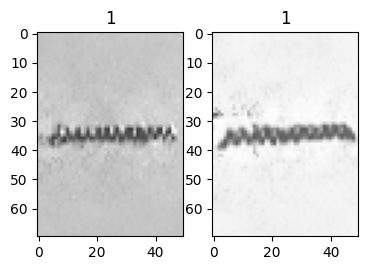

In [ ]:
plt.subplot(1,3,1)
plt.imshow(pairTrain[0][0])
plt.title(labelTrain[0][0])
plt.subplot(1,3,2)
plt.title(labelTrain[0][0])
plt.imshow(pairTrain[0][1])

In [ ]:
class config():
    IMG_SHAPE = (70, 50, 3)
    EMBEDDING_DIM = 48

    BATCH_SIZE = 64
    EPOCHS = 500

In [ ]:
def euclidean_distance(vectors):
    (featsA, featsB) = vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [ ]:
def loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [ ]:
class SiameseNetwork(tf.keras.Model):
    def __init__(self, inputShape, embeddingDim):
        super(SiameseNetwork, self).__init__()

        imgA = tf.keras.layers.Input(shape=inputShape)
        imgB = tf.keras.layers.Input(shape=inputShape)
        featureExtractor = self.build_feature_extractor(inputShape, embeddingDim)
        featsA = featureExtractor(imgA)
        featsB = featureExtractor(imgB)
        distance = tf.keras.layers.Lambda(euclidean_distance, name='euclidean_distance')([featsA, featsB])
        outputs = tf.keras.layers.Dense(1, activation="sigmoid")(distance)
        self.model = tf.keras.Model(inputs=[imgA, imgB], outputs=outputs)

    def build_feature_extractor(self, inputShape, embeddingDim=48):

        model = tf.keras.Sequential([
            tf.keras.layers.Input(inputShape),
            tf.keras.layers.Conv2D(64, (2, 2), padding="same", activation="relu"),
            tf.keras.layers.MaxPooling2D(pool_size=2),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Conv2D(64, (2, 2), padding="same", activation="relu"),
            tf.keras.layers.MaxPooling2D(pool_size=2),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Conv2D(128, (1, 1), padding="same", activation="relu"),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(embeddingDim, activation='tanh')
        ])

        return model

    def call(self, x):
        return self.model(x)

model = SiameseNetwork(inputShape=config.IMG_SHAPE, embeddingDim=config.EMBEDDING_DIM)
model.compile(loss=loss(margin=1), optimizer="adam", metrics=["accuracy"])

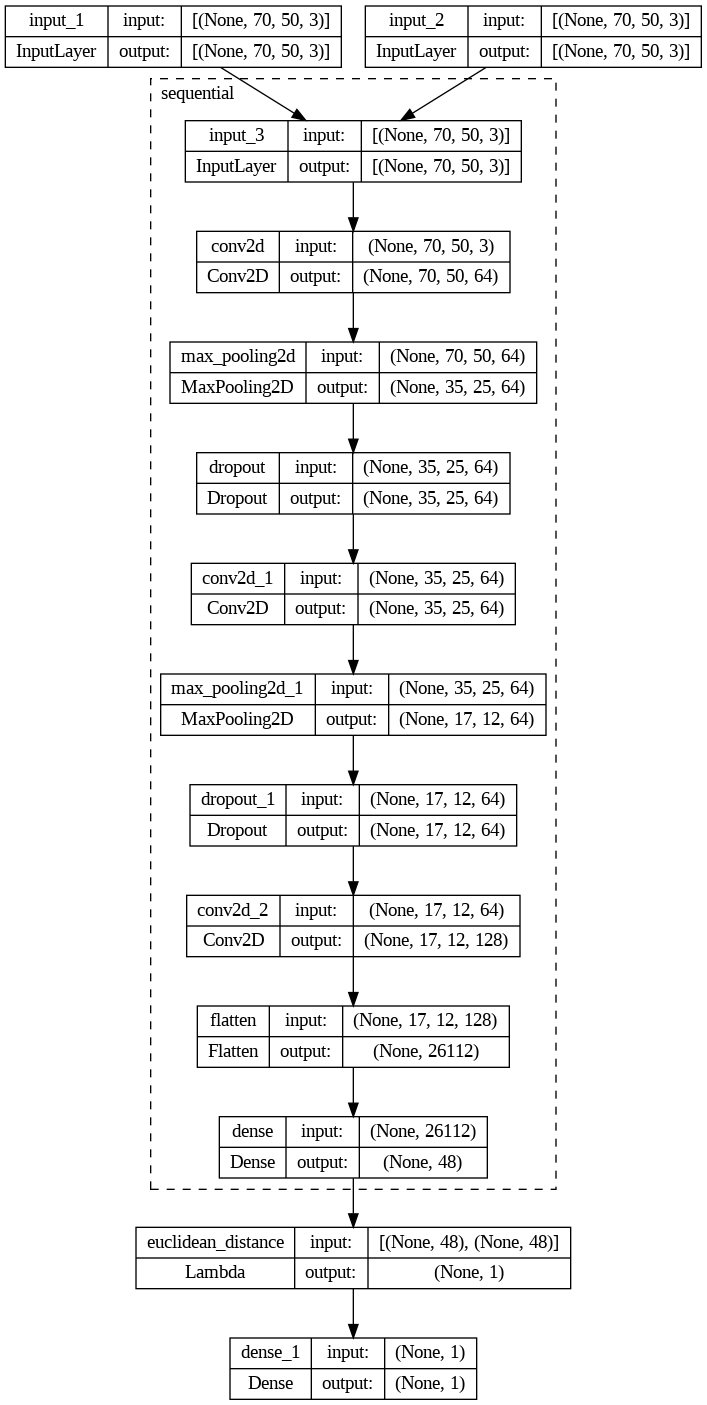

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model.model, show_shapes=True, expand_nested=True)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True, min_delta=1e-4)

rlp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, mode='min', verbose=1)

history = model.fit(
    [pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
    validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
    batch_size=config.BATCH_SIZE,
    epochs=config.EPOCHS,
    callbacks=[es, rlp]
)

Epoch 1/500
82/82 [==============================] - 12s 49ms/step - loss: 0.2418 - accuracy: 0.5325 - val_loss: 0.2371 - val_accuracy: 0.5726 - lr: 0.0010
Epoch 2/500
82/82 [==============================] - 2s 26ms/step - loss: 0.2085 - accuracy: 0.6907 - val_loss: 0.2407 - val_accuracy: 0.5925 - lr: 0.0010
Epoch 3/500
82/82 [==============================] - 2s 26ms/step - loss: 0.1978 - accuracy: 0.7336 - val_loss: 0.2314 - val_accuracy: 0.6621 - lr: 0.0010
Epoch 4/500
82/82 [==============================] - 2s 28ms/step - loss: 0.1914 - accuracy: 0.7412 - val_loss: 0.2343 - val_accuracy: 0.6391 - lr: 0.0010
Epoch 5/500
82/82 [==============================] - 3s 31ms/step - loss: 0.1880 - accuracy: 0.7471 - val_loss: 0.2264 - val_accuracy: 0.7095 - lr: 0.0010
Epoch 6/500
82/82 [==============================] - 2s 28ms/step - loss: 0.1662 - accuracy: 0.7957 - val_loss: 0.2238 - val_accuracy: 0.7049 - lr: 0.0010
Epoch 7/500
82/82 [==============================] - 2s 26ms/step - l

In [ ]:
preds = model.predict([pairTest[:, 0], pairTest[:, 1]])

41/41 [==============================] - 1s 4ms/step


In [ ]:
preds

array([[0.69781375],
       [0.29509354],
       [0.69781375],
       ...,
       [0.08835101],
       [0.6953633 ],
       [0.16533135]], dtype=float32)

In [ ]:
def create_batch(batch_size=128, test=False):
    anchors_list   = []
    positives_list = []
    negatives_list = []

    if test:
        y = y_t; x = x_test
    else:
        y = y_; x = x_train

    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = np.random.randint(0, x.shape[0] - 1)
        x_anchor = x[random_index]
        y_label = y[random_index]

        indices_for_pos =np.where(y == y_label)[0]
        indices_for_neg = np.where(y != y_label)[0]

        x_positive = x[indices_for_pos[np.random.randint(0, indices_for_pos.shape[0] )]]
        x_negative = x[indices_for_neg[np.random.randint(0, indices_for_neg.shape[0])]]
        anchors_list.append(x_anchor)
        positives_list.append(x_positive)
        negatives_list.append(x_negative)

    anchors_list = np.array(anchors_list, dtype='float32')
    positives_list = np.array(positives_list, dtype='float32')
    negatives_list = np.array(negatives_list, dtype='float32')

    return [anchors_list, positives_list, negatives_list]






In [ ]:
examples = create_batch(1)

In [ ]:
anc,pos,neg=examples

In [ ]:
anc

array([[[[0.9137255 , 0.9137255 , 0.9137255 ],
         [0.9134454 , 0.9134454 , 0.9134454 ],
         [0.9063025 , 0.9063025 , 0.9063025 ],
         ...,
         [0.9182073 , 0.9182073 , 0.9182073 ],
         [0.93319327, 0.93319327, 0.93319327],
         [0.9107843 , 0.9107843 , 0.9107843 ]],

        [[0.91414565, 0.91414565, 0.91414565],
         [0.90756303, 0.90756303, 0.90756303],
         [0.91722685, 0.91722685, 0.91722685],
         ...,
         [0.93039215, 0.93039215, 0.93039215],
         [0.9306723 , 0.9306723 , 0.9306723 ],
         [0.93557423, 0.93557423, 0.93557423]],

        [[0.91694677, 0.91694677, 0.91694677],
         [0.92016804, 0.92016804, 0.92016804],
         [0.9151261 , 0.9151261 , 0.9151261 ],
         ...,
         [0.90798324, 0.90798324, 0.90798324],
         [0.9411765 , 0.9411765 , 0.9411765 ],
         [0.9243697 , 0.9243697 , 0.9243697 ]],

        ...,

        [[0.88165265, 0.88165265, 0.88165265],
         [0.8600841 , 0.8600841 , 0.8600841 ]

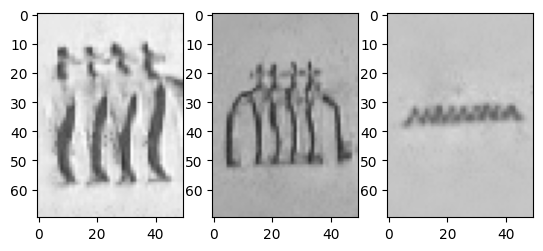

In [ ]:
plt.subplot(1,3,1)
plt.imshow(tf.squeeze(anc[0]))
plt.subplot(1,3,2)
plt.imshow(tf.squeeze(pos[0]))
plt.subplot(1,3,3)
plt.imshow(tf.squeeze(neg[0]))

In [ ]:
def data_generator(batch_size=128, test=False):
    while True:
        x = create_batch(batch_size, test)
        y = np.ones(batch_size)
        yield x, y

In [ ]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

def triplet_loss(x, alpha = 0.2):
    # Triplet Loss function.
    anchor,positive,negative = x
    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss

In [ ]:
label_range = np.unique(y_)
label_range

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 102, 103, 104, 105, 106,
       107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162])

In [ ]:
imsize = 70
im=50
batch_size = 32
LR = 0.0001

def embedding_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), activation='relu', input_shape=(70,50,3)))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(159))
    return model

def complete_model(base_model):
    input_1 = tf.keras.layers.Input((imsize, im, 3), name="input_1")
    input_2 = tf.keras.layers.Input((imsize, im, 3), name="input_2")
    input_3 = tf.keras.layers.Input((imsize, im, 3), name="input_3")

    loss = tf.keras.layers.Lambda(triplet_loss)([base_model(input_1), base_model(input_2), base_model(input_3)])
    model = tf.keras.Model(inputs=[input_1, input_2, input_3], outputs=loss)
    model.compile(loss=identity_loss, optimizer=tf.keras.optimizers.Adam(LR))

    return model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 70, 50, 3)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 70, 50, 3)]          0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 70, 50, 3)]          0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 159)                  2152137   ['input_1[0][0]',             
                                                          5          'input_2[0][0]',       

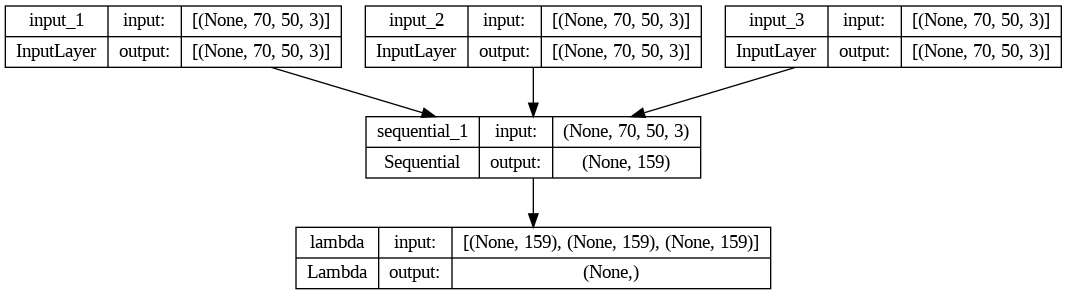

In [ ]:
base_model = embedding_model()
model = complete_model(base_model)
model.summary()

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='siamanese_network.png', show_shapes=True, show_layer_names=True)

In [ ]:
train_generator = data_generator(batch_size)
test_generator = data_generator(batch_size, test=True)

checkpoint_last = tf.keras.callbacks.ModelCheckpoint('last_weights.h5',
                                  monitor='val_loss',
                                  save_best_only=True,
                                  save_weights_only = False,
                                  verbose=1)

steps_per_epoch = int(x_train.shape[0]/batch_size)
validation_steps = int(x_test.shape[0]/batch_size)

history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs = 10,
                    verbose = 1,
                    steps_per_epoch = steps_per_epoch,
                    callbacks=[checkpoint_last],
                    validation_steps = validation_steps)

Epoch 1/10
81/81 [==============================] - ETA: 0s - loss: 0.1069
Epoch 1: val_loss improved from inf to 0.03005, saving model to last_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


81/81 [==============================] - 10s 85ms/step - loss: 0.1069 - val_loss: 0.0300
Epoch 2/10
81/81 [==============================] - ETA: 0s - loss: 0.0408
Epoch 2: val_loss improved from 0.03005 to 0.02828, saving model to last_weights.h5
81/81 [==============================] - 5s 59ms/step - loss: 0.0408 - val_loss: 0.0283
Epoch 3/10
81/81 [==============================] - ETA: 0s - loss: 0.0306
Epoch 3: val_loss improved from 0.02828 to 0.02247, saving model to last_weights.h5
81/81 [==============================] - 5s 63ms/step - loss: 0.0306 - val_loss: 0.0225
Epoch 4/10
80/81 [============================>.] - ETA: 0s - loss: 0.0259
Epoch 4: val_loss improved from 0.02247 to 0.02202, saving model to last_weights.h5
81/81 [==============================] - 5s 61ms/step - loss: 0.0260 - val_loss: 0.0220
Epoch 5/10
80/81 [============================>.] - ETA: 0s - loss: 0.0272
Epoch 5: val_loss improved from 0.02202 to 0.01759, saving model to last_weights.h5
81/81 [====

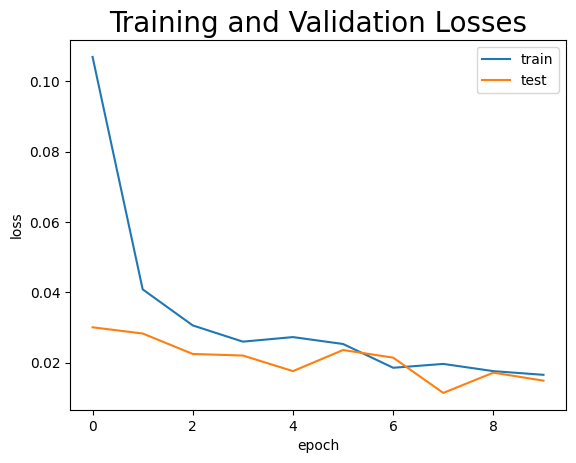

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Losses',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
from sklearn.manifold import TSNE

X_train_trm = base_model.predict(x_train)
X_test_trm = base_model.predict(x_test)

# TSNE to use dimensionality reduction to visulaise the resultant embeddings
tsne = TSNE()
test_tsne_embeds = tsne.fit_transform(X_test_trm)

21/21 [==============================] - 0s 11ms/step


In [ ]:
base_model.save('baseSiamense.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
Classifier_input = tf.keras.layers.Input((159,))
Classifier_output = tf.keras.layers.Dense(163, activation='softmax')(Classifier_input)
Classifier_model = tf.keras.Model(Classifier_input, Classifier_output)

# convert the target labels to onehot encoded vectors.
# Y_train_onehot = to_categorical(y_train, 24)
# Y_test_onehot = to_categorical(y_test, 24)

Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(X_train_trm,y_train, validation_data=(X_test_trm,y_test),epochs=500)

Epoch 1/500
82/82 [==============================] - 1s 5ms/step - loss: 4.7706 - accuracy: 0.3215 - val_loss: 4.4651 - val_accuracy: 0.5122
Epoch 2/500
82/82 [==============================] - 0s 4ms/step - loss: 4.1651 - accuracy: 0.5386 - val_loss: 3.9258 - val_accuracy: 0.5474
Epoch 3/500
82/82 [==============================] - 0s 4ms/step - loss: 3.6418 - accuracy: 0.5558 - val_loss: 3.4649 - val_accuracy: 0.5505
Epoch 4/500
82/82 [==============================] - 0s 5ms/step - loss: 3.2060 - accuracy: 0.5642 - val_loss: 3.1000 - val_accuracy: 0.5550
Epoch 5/500
82/82 [==============================] - 0s 5ms/step - loss: 2.8634 - accuracy: 0.5673 - val_loss: 2.8235 - val_accuracy: 0.5612
Epoch 6/500
82/82 [==============================] - 0s 6ms/step - loss: 2.6054 - accuracy: 0.5795 - val_loss: 2.6195 - val_accuracy: 0.5673
Epoch 7/500
82/82 [==============================] - 0s 5ms/step - loss: 2.4118 - accuracy: 0.5887 - val_loss: 2.4674 - val_accuracy: 0.5673
Epoch 8/500
8

In [ ]:
eval_siamense=Classifier_model.evaluate(X_test_trm,y_test)

21/21 [==============================] - 0s 3ms/step - loss: 1.0876 - accuracy: 0.7722


In [ ]:
Classifier_model.save('ModelSiamense.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
pred_siamense = Classifier_model.predict(X_test_trm)

21/21 [==============================] - 0s 1ms/step


In [ ]:
a=np.argmax(pred_siamense,axis=1)
a

array([ 56,  56,  45,  68,  63, 135, 160, 121,  82, 121,  95,  68,  56,
        11, 153, 121,  93,  26, 141, 139,  45,  11,   8, 153,  45,   8,
       160,  63, 107, 141,  95,  63,  68,  12,  92, 129,  26, 141,  95,
        68,  68, 121, 151, 103,  69,  63,  68, 109,  63,  92,  63,  68,
       121,  42, 129,  57,  12,  45,  79,  63, 141, 121,  63,  57, 107,
        50,  95,  63,  68, 135,  56,   8,  15,  45,  45, 153, 121,  14,
         8, 121, 153, 141, 112, 153,  11,  68, 135,  95,  45, 107,  68,
        95,  56, 160,  11,  69,   8, 135, 139, 107, 141,  56, 121,  63,
        19, 121,  95,  45,  45,  26,  68,  86,  45,  45,   8, 151, 142,
        15, 104,   8,  95,  45, 121,  83,   5, 121,   8,  45,  63,  68,
       153, 153,  12, 107,  72, 121,  12, 141,  93,  53, 107,  45,  26,
       115,  95,  18,  30,  68,  56,  26, 153,  95, 121,  95,  68,  21,
       153,  68, 106,  39, 121, 121, 121, 115, 118, 115,  56,  95, 107,
        56,  79,  68, 135,  56,  26,   9,  15,  42,  68,  45,  6

In [ ]:
pred_code = [data_val_2.class_names[i] for i in a]
pred_code

['G43',
 'G43',
 'G17',
 'M17',
 'I9',
 'V13',
 'Z1',
 'S29',
 'N1',
 'S29',
 'N35',
 'M17',
 'G43',
 'D35',
 'X1',
 'S29',
 'N30',
 'E34',
 'V31',
 'V28',
 'G17',
 'D35',
 'D21',
 'X1',
 'G17',
 'D21',
 'Z1',
 'I9',
 'O50',
 'V31',
 'N35',
 'I9',
 'M17',
 'D36',
 'N29',
 'U1',
 'E34',
 'V31',
 'N35',
 'M17',
 'M17',
 'S29',
 'W24',
 'O31',
 'M18',
 'I9',
 'M17',
 'P1',
 'I9',
 'N29',
 'I9',
 'M17',
 'S29',
 'G1',
 'U1',
 'G5',
 'D36',
 'G17',
 'M42',
 'I9',
 'V31',
 'S29',
 'I9',
 'G5',
 'O50',
 'G35',
 'N35',
 'I9',
 'M17',
 'V13',
 'G43',
 'D21',
 'D46',
 'G17',
 'G17',
 'X1',
 'S29',
 'D4',
 'D21',
 'S29',
 'X1',
 'V31',
 'P8',
 'X1',
 'D35',
 'M17',
 'V13',
 'N35',
 'G17',
 'O50',
 'M17',
 'N35',
 'G43',
 'Z1',
 'D35',
 'M18',
 'D21',
 'V13',
 'V28',
 'O50',
 'V31',
 'G43',
 'S29',
 'I9',
 'D56',
 'S29',
 'N35',
 'G17',
 'G17',
 'E34',
 'M17',
 'N18',
 'G17',
 'G17',
 'D21',
 'W24',
 'V4',
 'D46',
 'O34',
 'D21',
 'N35',
 'G17',
 'S29',
 'N14',
 'D156',
 'S29',
 'D21',
 'G17',
 'I

In [ ]:
read_im = plt.imread('/content/Dataset/Pictures/egyptianTexts20.jpg')
read_im=read_im/255.
read_im

array([[[0.3372549 , 0.3372549 , 0.3372549 ],
        [0.4       , 0.4       , 0.4       ],
        [0.39215686, 0.39215686, 0.39215686],
        ...,
        [0.52941176, 0.52941176, 0.52941176],
        [0.77254902, 0.77254902, 0.77254902],
        [0.91764706, 0.91764706, 0.91764706]],

       [[0.34901961, 0.34901961, 0.34901961],
        [0.41568627, 0.41568627, 0.41568627],
        [0.44705882, 0.44705882, 0.44705882],
        ...,
        [0.52941176, 0.52941176, 0.52941176],
        [0.74509804, 0.74509804, 0.74509804],
        [0.90588235, 0.90588235, 0.90588235]],

       [[0.42352941, 0.42352941, 0.42352941],
        [0.46666667, 0.46666667, 0.46666667],
        [0.45490196, 0.45490196, 0.45490196],
        ...,
        [0.50196078, 0.50196078, 0.50196078],
        [0.72156863, 0.72156863, 0.72156863],
        [0.90980392, 0.90980392, 0.90980392]],

       ...,

       [[0.90196078, 0.90196078, 0.90196078],
        [0.94901961, 0.94901961, 0.94901961],
        [0.38431373, 0

In [ ]:
image_height, image_width, _ = read_im.shape

# Calculate starting and ending coordinates considering desired aspect ratio
start_y = (image_height - 240) // 2
end_y = start_y + 240
start_x = (image_width - 426) // 2
end_x = start_x + 426

# Check if coordinates fall outside image boundaries (adjust if needed)
if start_y < 0 or end_y > image_height or start_x < 0 or end_x > image_width:
    # Implement logic to handle edge cases like image being smaller than desired size
    print("Image too small for desired crop size")
    # ...

cropped_image = read_im[start_y:end_y, start_x:end_x]

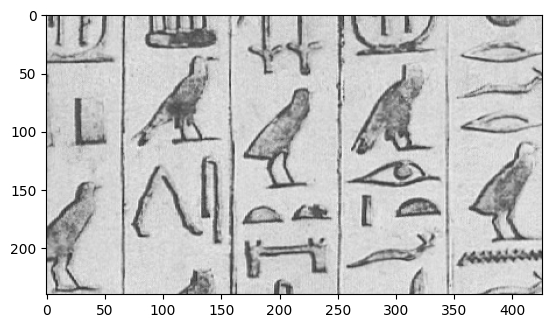

In [ ]:
plt.imshow(cropped_image)

In [ ]:
c=cropped_image[30:100, 100:150]
b = base_model.predict(tf.expand_dims(c,axis=0))
v=Classifier_model.predict(b)
x=np.argmax(v)
x

1/1 [==============================] - 0s 18ms/step


56

In [ ]:
data_val_2.class_names[56]

'G43'

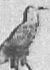

In [ ]:
cv2_imshow(cropped_image[30:100, 100:150])

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
read_im = plt.imread('/content/Dataset/Pictures/egyptianTexts20.jpg')
image_height, image_width, _ = read_im.shape

# Calculate starting and ending coordinates considering desired aspect ratio
start_y = (image_height - 240) // 2
end_y = start_y + 240
start_x = (image_width - 426) // 2
end_x = start_x + 426

# Check if coordinates fall outside image boundaries (adjust if needed)
if start_y < 0 or end_y > image_height or start_x < 0 or end_x > image_width:
    # Implement logic to handle edge cases like image being smaller than desired size
    print("Image too small for desired crop size")
    # ...

cropped_image = read_im[start_y:end_y, start_x:end_x]

In [ ]:
read_im = plt.imread('/content/Dataset/Pictures/egyptianTexts20.jpg')
im = read_im[:363,2:100]
c=im.resize(,50)
gray = cv2.cvtColor(read_im, cv2.COLOR_BGR2GRAY)

plt.imshow(im)
gray.shape

SyntaxError: ignored

In [ ]:
import argparse
import cv2

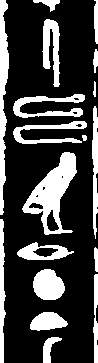

In [ ]:
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)
thresh = cv2.threshold(blurred, 0, 255,
cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
cv2_imshow(thresh)

In [ ]:
output = cv2.connectedComponentsWithStats(
	thresh, 4, cv2.CV_32S)
(numLabels, labels, stats, centroids) = output

In [ ]:
stats[0]

array([    0,     0,    98,   363, 26370], dtype=int32)

In [ ]:
print(numLabels)

19


[INFO] examining component 1/19 (background)


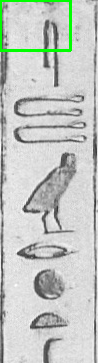

[INFO] examining component 2/19
[INFO] examining component 3/19


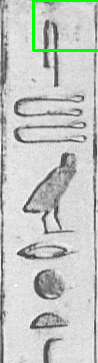

[INFO] examining component 4/19
[INFO] examining component 5/19


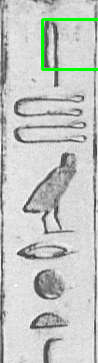

[INFO] examining component 6/19
[INFO] examining component 7/19
[INFO] examining component 8/19


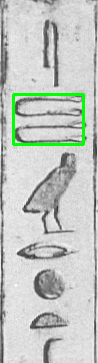

[INFO] examining component 9/19
[INFO] examining component 10/19


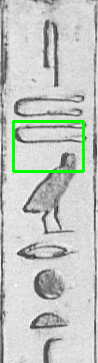

[INFO] examining component 11/19
[INFO] examining component 12/19


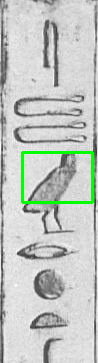

[INFO] examining component 13/19
[INFO] examining component 14/19


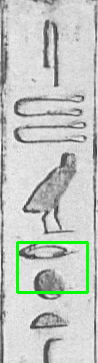

[INFO] examining component 15/19
[INFO] examining component 16/19


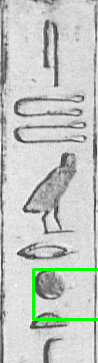

[INFO] examining component 17/19
[INFO] examining component 18/19


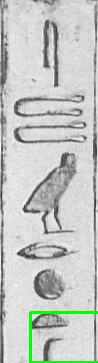

[INFO] examining component 19/19


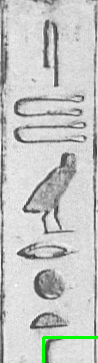

In [ ]:
li_images=[]
for i in range(0, numLabels):
    # if this is the first component then we examine the
    # *background* (typically we would just ignore this
    # component in our loop)
    if i == 0:
        text = "examining component {}/{} (background)".format(
            i + 1, numLabels)
    # otherwise, we are examining an actual connected component
    else:
        text = "examining component {}/{}".format( i + 1, numLabels)
    # print a status message update for the current connected
    # component
    print("[INFO] {}".format(text))
    # extract the connected component statistics and centroid for
    # the current label
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]

    output = im.copy()

    if h>5 and w>10:
      lol=output[y:y+70,x:x+50]

      li_images.append(lol)
      cv2.rectangle(output, (x, y), (x+70, y+50), (0, 255, 0), 2)
      cv2_imshow(output)



In [ ]:
images_np=np.array(li_images)
images_np[-3].shape

<ipython-input-50-cd3b51864067>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images_np=np.array(li_images)


(70, 50, 3)

In [ ]:
load_Classification =tf.keras.models.load_model('/content/ModelSiamense.h5')
load_base = tf.keras.models.load_model('/content/baseSiamense.h5')

In [ ]:
np.argmax(load_base.predict(tf.expand_dims(images_np[1],axis=0)))

1/1 [==============================] - 0s 34ms/step


33

In [ ]:
txt = ""
for i in range(1,len(images_np)-2):
  window=images_np[i]/255.
  first_pred = load_base.predict(tf.expand_dims(window,axis=0))
  second = load_Classification.predict(first_pred)
  max=np.argmax(second)
  txt=txt+' '+data_train_2.class_names[max]

In [ ]:
txt

' F9 D58 N14 M23 G43 O4 D58'

In [ ]:
text = txt

from transformers import AutoTokenizer
from transformers import pipeline

pipe = pipeline("text2text-generation", model="AnushS/Hieroglyph-Translator-Using-Gardiner-Codes")



from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("AnushS/Hieroglyph-Translator-Using-Gardiner-Codes")
inputs = tokenizer(text, return_tensors="pt").input_ids
print(inputs)
model = AutoModelForSeq2SeqLM.from_pretrained("AnushS/Hieroglyph-Translator-Using-Gardiner-Codes")
outputs = model.generate(inputs, max_new_tokens=40, do_sample=True, top_k=30, top_p=0.95)
translated_keywords = str(tokenizer.decode(outputs[0], skip_special_tokens=True))

print(translated_keywords)


tensor([[ 377, 1298,  309, 3449,  445, 2534,  283, 2773,  350, 4906,  411,  591,
          309, 3449,    1]])
sceptre


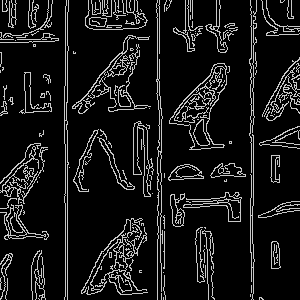

81 218 77 67


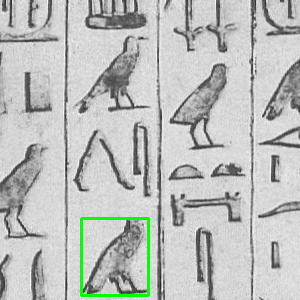

In [ ]:
# Import libraries
import cv2

# Load image
image = cropped_image

# Grayscale conversion and edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
noise=cv2.bilateralFilter(gray, 9, 9, 80, 80)
edges = cv2.Canny(noise, 50, 150)
binary = cv2.threshold(edges, 127, 200, cv2.THRESH_BINARY)[1]
cv2_imshow(binary)
# Find characters
contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
li=[]
# Draw rectangles
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w>20:
      print(x,y,h,w)
      li.append(image[x:y+h,y:x+w])
      cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
      break

# Display results
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

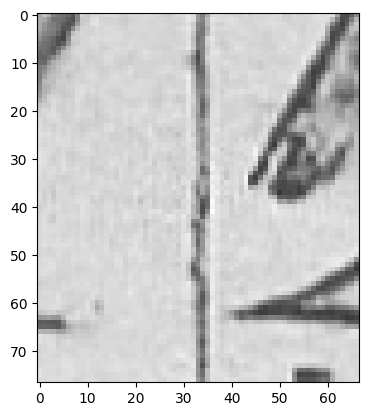

In [ ]:
plt.imshow(image[81:81+77,218:218+67])